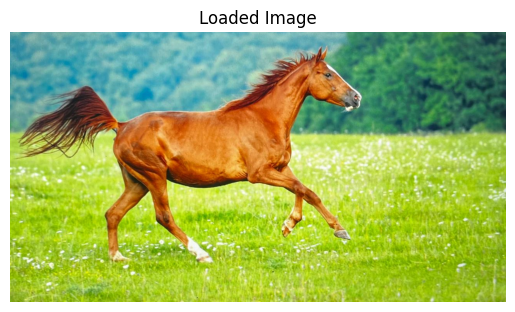

Image Shape: torch.Size([3, 698, 1280])


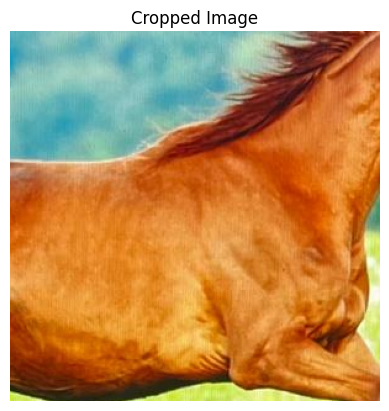

Crop coordinates: Top-left corner (y: 102, x: 435)


In [28]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load the image as a tensor
img = torchvision.io.read_image("/kaggle/input/uydgcysg/Machine_learning.jpeg").float() / 255.0

# Check if the image has 4 channels (RGBA) and convert to RGB if necessary
if img.shape[0] == 4:
    img = img[:3, :, :]  # Use only RGB channels

# Display the image to ensure it's loaded correctly
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title("Loaded Image")
plt.axis('off')
plt.show()

# Print the shape of the image
print(f"Image Shape: {img.shape}")

# Check if the image has 4 channels (RGBA) and convert to RGB if necessary
if img.shape[0] == 4:
    img = img[:3, :, :]  # Use only RGB channels

# Set a fixed seed for reproducibility
np.random.seed(42)

# Get image dimensions
num_channels, height, width = img.shape

# Define the crop size (e.g., 100x100 pixels)
crop_height = 300
crop_width = 300

# Randomly choose the top-left corner of the crop
top = np.random.randint(0, height - crop_height)
left = np.random.randint(0, width - crop_width)

# Crop the image using the calculated coordinates
cropped_img = img[:, top:top+crop_height, left:left+crop_width]

# Display the cropped image
plt.imshow(cropped_img.permute(1, 2, 0).numpy())
plt.title("Cropped Image")
plt.axis('off')
plt.show()

# Print out the top-left coordinates of the crop
print(f"Crop coordinates: Top-left corner (y: {top}, x: {left})")

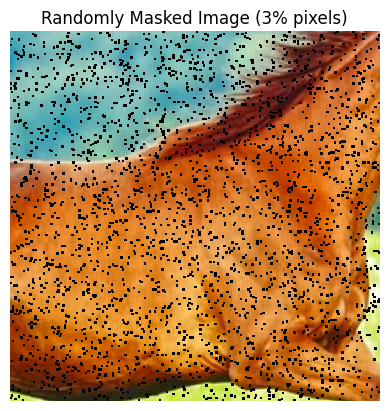

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

# Define the percentage of pixels to mask (e.g., mask 30% of the image)
mask_ratio = 0.03

# Flatten the image for easier masking
masked_img = cropped_img.clone().numpy()
num_channels, height, width = masked_img.shape
num_pixels = height * width

# Number of pixels to mask
num_masked_pixels = int(mask_ratio * num_pixels)

# Randomly choose the indices to mask across the entire image
masked_indices = np.random.choice(num_pixels, num_masked_pixels, replace=False)

# Convert the masked indices to 2D coordinates (height, width)
masked_coords = np.unravel_index(masked_indices, (height, width))

# Apply the mask by setting random pixels to NaN or some constant value (like 0)
for c in range(num_channels):
    masked_img[c, masked_coords[0], masked_coords[1]] = np.nan  # Or set to 0 for blacked out pixels

# Convert back to tensor
masked_img_tensor = torch.tensor(masked_img)

# Display the masked image
plt.imshow(masked_img_tensor.permute(1, 2, 0).numpy())
plt.title(f"Randomly Masked Image ({mask_ratio * 100:.0f}% pixels)")
plt.axis('off')
plt.show()


In [36]:
import torch
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

# Matrix Factorization function
def factorize_part(masked_img, rank, device):
    # Flatten the image
    img_flat = masked_img.flatten(start_dim=1)  # Flatten the spatial dimensions

    # Create a mask for known pixels (non-masked pixels)
    mask_flat = ~torch.isnan(img_flat)

    # Initialize matrices W and H
    W = torch.randn(masked_img.shape[0], rank, device=device, requires_grad=True)
    H = torch.randn(rank, masked_img.shape[1] * masked_img.shape[2], device=device, requires_grad=True)

    # Optimizer and loss function
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Gradient descent
    for i in range(500):
        optimizer.zero_grad()
        pred = torch.mm(W, H)
        pred_masked = pred * mask_flat  # Only consider known values for training
        loss = criterion(torch.nan_to_num(img_flat), pred_masked)
        loss.backward()
        optimizer.step()

    return W, H

# Function to reconstruct the image from W and H
def predict_missing(W, H, img_shape):
    pred = torch.mm(W, H).reshape(img_shape)
    return pred.cpu().detach().numpy()

# Apply Matrix Factorization to each channel
rank = 500  # You can adjust the rank
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

masked_img_tensor = masked_img_tensor.to(device)
W_r, H_r = factorize_part(masked_img_tensor[0], rank, device)
W_g, H_g = factorize_part(masked_img_tensor[1], rank, device)
W_b, H_b = factorize_part(masked_img_tensor[2], rank, device)

# Reconstruct the image
reconstructed_r = predict_missing(W_r, H_r, (height, width))
reconstructed_g = predict_missing(W_g, H_g, (height, width))
reconstructed_b = predict_missing(W_b, H_b, (height, width))

# Stack the reconstructed channels
reconstructed_img_matrix_factorization = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=0)

# Step 4: Calculate RMSE and PSNR between original and reconstructed image

# Compute RMSE for each channel and the overall image
rmse_r = np.sqrt(mse(cropped_img[0].cpu().numpy(), reconstructed_r))
rmse_g = np.sqrt(mse(cropped_img[1].cpu().numpy(), reconstructed_g))
rmse_b = np.sqrt(mse(cropped_img[2].cpu().numpy(), reconstructed_b))
rmse_total = np.sqrt(mse(cropped_img.cpu().numpy().flatten(), reconstructed_img_matrix_factorization.flatten()))

# Compute PSNR for the overall image
psnr_value = psnr(cropped_img.cpu().numpy(), reconstructed_img_matrix_factorization, data_range=1)

print(f"RMSE (R): {rmse_r:.4f}")
print(f"RMSE (G): {rmse_g:.4f}")
print(f"RMSE (B): {rmse_b:.4f}")
print(f"Total RMSE: {rmse_total:.4f}")
print(f"PSNR: {psnr_value:.2f}")

# Plot the reconstructed image
plt.imshow(reconstructed_img_matrix_factorization.transpose(1, 2, 0))  # (H, W, C)
plt.title("Reconstructed Image Using Matrix Factorization")
plt.axis('off')
plt.show()


IndexError: tuple index out of range

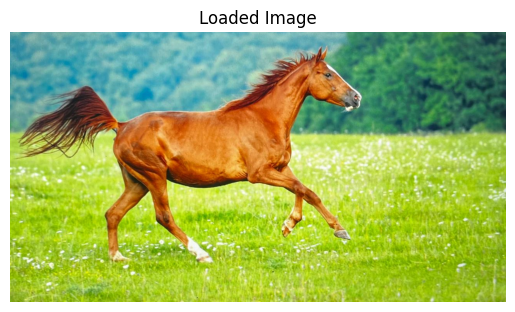

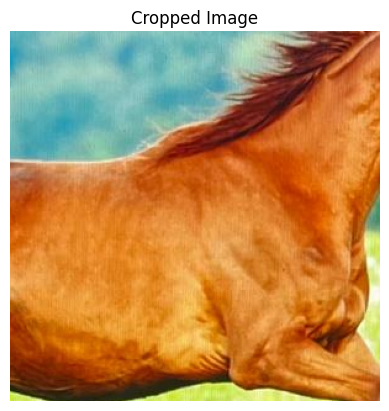

/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


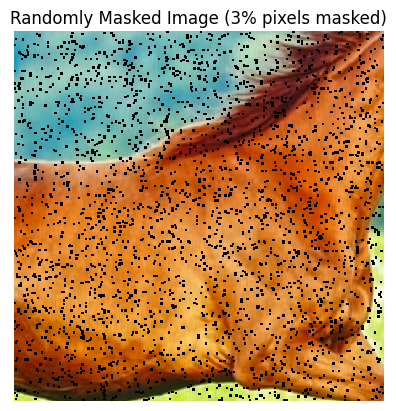

Iteration 0, Loss: 1476.9361572265625
Iteration 100, Loss: 0.011399438604712486
Iteration 200, Loss: 3.683087470562896e-07
Iteration 300, Loss: 7.932311058000963e-12
Iteration 400, Loss: 7.207341277612467e-13
Iteration 0, Loss: 1513.36572265625
Iteration 100, Loss: 0.01187060959637165
Iteration 200, Loss: 3.8037953231651045e-07
Iteration 300, Loss: 8.140653949550991e-12
Iteration 400, Loss: 7.250451324394835e-13
Iteration 0, Loss: 1507.983642578125
Iteration 100, Loss: 0.01184246689081192
Iteration 200, Loss: 3.786992692766944e-07
Iteration 300, Loss: 8.111906112107103e-12
Iteration 400, Loss: 6.893036488819781e-13
RMSE (R): 5.9530
RMSE (G): 5.9241
RMSE (B): 6.0500
Total RMSE: 5.9760
PSNR: -15.53


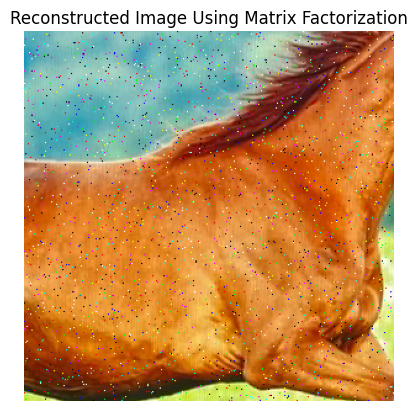

In [42]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load the image
img = torchvision.io.read_image("/kaggle/input/uydgcysg/Machine_learning.jpeg").float() / 255.0

# Convert RGBA to RGB if necessary
if img.shape[0] == 4:
    img = img[:3, :, :]  # Use only the RGB channels

# Display the loaded image
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title("Loaded Image")
plt.axis('off')
plt.show()

# Crop the image randomly
np.random.seed(42)  # For reproducibility
num_channels, height, width = img.shape
crop_height, crop_width = 300, 300

# Random top-left corner for cropping
top = np.random.randint(0, height - crop_height)
left = np.random.randint(0, width - crop_width)

cropped_img = img[:, top:top + crop_height, left:left + crop_width]

# Display the cropped image
plt.imshow(cropped_img.permute(1, 2, 0).numpy())
plt.title("Cropped Image")
plt.axis('off')
plt.show()

# Masking process
mask_ratio = 0.03  # Mask 30% of the image

# Create the mask
masked_img = cropped_img.clone().numpy()  # Convert tensor to numpy for easy masking
num_pixels = crop_height * crop_width
num_masked_pixels = int(mask_ratio * num_pixels)

# Randomly select pixels to mask
masked_indices = np.random.choice(num_pixels, num_masked_pixels, replace=False)
masked_coords = np.unravel_index(masked_indices, (crop_height, crop_width))

# Apply the mask by setting selected pixels to NaN
for c in range(num_channels):
    masked_img[c, masked_coords[0], masked_coords[1]] = np.nan

# Convert back to tensor with NaN values for masked pixels
masked_img_tensor = torch.tensor(masked_img)

# Display the masked image
plt.imshow(masked_img_tensor.permute(1, 2, 0).numpy())
plt.title(f"Randomly Masked Image ({mask_ratio * 100:.0f}% pixels masked)")
plt.axis('off')
plt.show()


# Matrix Factorization function
def factorize_part(masked_img_channel, rank, device, num_iters=500):
    # Flatten the image for the channel
    height, width = masked_img_channel.shape
    img_flat = masked_img_channel.flatten().unsqueeze(0)  # Flatten to a single row

    # Create a mask for known pixels (non-masked pixels)
    mask_flat = ~torch.isnan(img_flat)

    # Initialize matrices W and H
    W = torch.randn(1, rank, device=device, requires_grad=True)  # 1 x rank
    H = torch.randn(rank, height * width, device=device, requires_grad=True)  # rank x (height * width)

    # Optimizer and loss function
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Gradient descent
    for i in range(num_iters):
        optimizer.zero_grad()
        pred = torch.mm(W, H)  # Predicted image
        pred_masked = pred * mask_flat  # Apply the mask to consider only known values
        loss = criterion(torch.nan_to_num(img_flat), pred_masked)  # Compute loss only for known values
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H

# Function to reconstruct the image from W and H
def predict_missing(W, H, img_shape):
    pred = torch.mm(W, H).reshape(img_shape)  # Reshape to original (height, width)
    return pred.cpu().detach().numpy()

# Apply Matrix Factorization to each channel
rank = 1500  # You can adjust the rank
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

masked_img_tensor = masked_img_tensor.to(device)

# Separate each channel (R, G, B) before applying factorization
W_r, H_r = factorize_part(masked_img_tensor[0, :, :], rank, device)
W_g, H_g = factorize_part(masked_img_tensor[1, :, :], rank, device)
W_b, H_b = factorize_part(masked_img_tensor[2, :, :], rank, device)

# Reconstruct the image for each channel
height, width = masked_img_tensor.shape[1], masked_img_tensor.shape[2]
reconstructed_r = predict_missing(W_r, H_r, (height, width))
reconstructed_g = predict_missing(W_g, H_g, (height, width))
reconstructed_b = predict_missing(W_b, H_b, (height, width))

# Stack the reconstructed channels back together
reconstructed_img_matrix_factorization = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=0)

# Step 4: Calculate RMSE and PSNR between original and reconstructed image

# Compute RMSE for each channel and the overall image
rmse_r = np.sqrt(mse(cropped_img[0].cpu().numpy(), reconstructed_r))
rmse_g = np.sqrt(mse(cropped_img[1].cpu().numpy(), reconstructed_g))
rmse_b = np.sqrt(mse(cropped_img[2].cpu().numpy(), reconstructed_b))
rmse_total = np.sqrt(mse(cropped_img.cpu().numpy().flatten(), reconstructed_img_matrix_factorization.flatten()))

# Compute PSNR for the overall image
psnr_value = psnr(cropped_img.cpu().numpy(), reconstructed_img_matrix_factorization, data_range=1)

print(f"RMSE (R): {rmse_r:.4f}")
print(f"RMSE (G): {rmse_g:.4f}")
print(f"RMSE (B): {rmse_b:.4f}")
print(f"Total RMSE: {rmse_total:.4f}")
print(f"PSNR: {psnr_value:.2f}")

# Plot the reconstructed image
plt.imshow(reconstructed_img_matrix_factorization.transpose(1, 2, 0))  # (H, W, C)
plt.title("Reconstructed Image Using Matrix Factorization")
plt.axis('off')
plt.show()



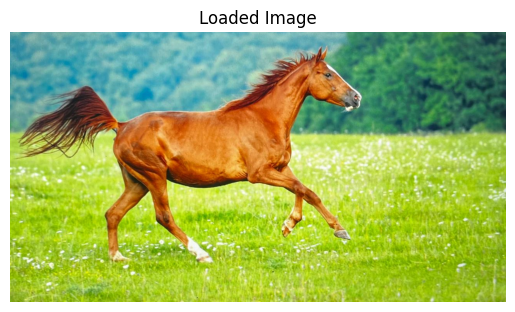

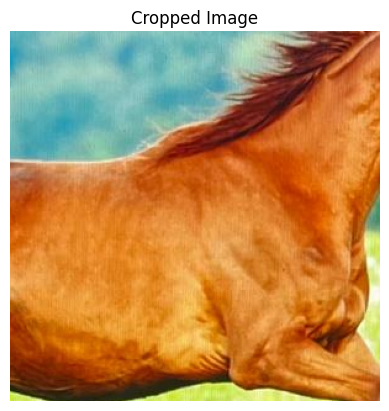

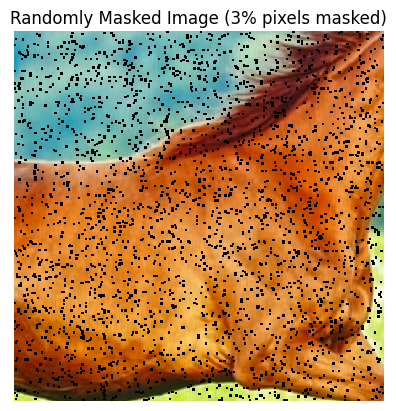

OutOfMemoryError: CUDA out of memory. Tried to allocate 688.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 484.12 MiB is free. Process 2480 has 14.27 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 28.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [49]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load the image
img = torchvision.io.read_image("/kaggle/input/uydgcysg/Machine_learning.jpeg").float() / 255.0

# Convert RGBA to RGB if necessary
if img.shape[0] == 4:
    img = img[:3, :, :]  # Use only the RGB channels

# Display the loaded image
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title("Loaded Image")
plt.axis('off')
plt.show()

# Crop the image randomly
np.random.seed(42)  # For reproducibility
num_channels, height, width = img.shape
crop_height, crop_width = 300, 300

# Random top-left corner for cropping
top = np.random.randint(0, height - crop_height)
left = np.random.randint(0, width - crop_width)

cropped_img = img[:, top:top + crop_height, left:left + crop_width]

# Display the cropped image
plt.imshow(cropped_img.permute(1, 2, 0).numpy())
plt.title("Cropped Image")
plt.axis('off')
plt.show()

# Masking process
mask_ratio = 0.03  # Mask 3% of the image

# Create the mask
masked_img = cropped_img.clone().numpy()  # Convert tensor to numpy for easy masking
num_pixels = crop_height * crop_width
num_masked_pixels = int(mask_ratio * num_pixels)

# Randomly select pixels to mask
masked_indices = np.random.choice(num_pixels, num_masked_pixels, replace=False)
masked_coords = np.unravel_index(masked_indices, (crop_height, crop_width))

# Apply the mask by setting selected pixels to NaN
for c in range(num_channels):
    masked_img[c, masked_coords[0], masked_coords[1]] = np.nan

# Convert back to tensor with NaN values for masked pixels
masked_img_tensor = torch.tensor(masked_img)

# Display the masked image
plt.imshow(masked_img_tensor.permute(1, 2, 0).numpy())
plt.title(f"Randomly Masked Image ({mask_ratio * 100:.0f}% pixels masked)")
plt.axis('off')
plt.show()

# Matrix Factorization function with refinement for masked parts
def factorize_part(masked_img_channel, rank, device, num_iters=500):
    # Flatten the image for the channel
    height, width = masked_img_channel.shape
    img_flat = masked_img_channel.flatten().unsqueeze(0)  # Flatten to a single row

    # Create a mask for known pixels (non-masked pixels)
    mask_flat = ~torch.isnan(img_flat)

    # Initialize matrices W and H
    W = torch.randn(1, rank, device=device, requires_grad=True)  # 1 x rank
    H = torch.randn(rank, height * width, device=device, requires_grad=True)  # rank x (height * width)

    # Optimizer and loss function
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Pre-fill the missing values with zeros or some initial guess
    img_flat_filled = torch.nan_to_num(img_flat)

    # Gradient descent with masked pixel refinement
    for i in range(num_iters):
        optimizer.zero_grad()
        
        # Predicted full image (W * H)
        pred = torch.mm(W, H)
        
        # Initially only use non-masked pixels to guide factorization
        if i < num_iters // 2:
            pred_masked = pred * mask_flat  # Apply the mask to only consider known values
            loss = criterion(img_flat_filled, pred_masked)  # Compute loss only for known values
        else:
            # Gradually use the entire image, including masked regions
            loss = criterion(img_flat_filled, pred)
        
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H

# Function to reconstruct the image from W and H
def predict_missing(W, H, img_shape):
    pred = torch.mm(W, H).reshape(img_shape)  # Reshape to original (height, width)
    return pred.cpu().detach().numpy()

# Apply Matrix Factorization to each channel
rank = 2000  # You can adjust the rank
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

masked_img_tensor = masked_img_tensor.to(device)

# Separate each channel (R, G, B) before applying factorization
W_r, H_r = factorize_part(masked_img_tensor[0, :, :], rank, device)
W_g, H_g = factorize_part(masked_img_tensor[1, :, :], rank, device)
W_b, H_b = factorize_part(masked_img_tensor[2, :, :], rank, device)

# Reconstruct the image for each channel
height, width = masked_img_tensor.shape[1], masked_img_tensor.shape[2]
reconstructed_r = predict_missing(W_r, H_r, (height, width))
reconstructed_g = predict_missing(W_g, H_g, (height, width))
reconstructed_b = predict_missing(W_b, H_b, (height, width))

# Stack the reconstructed channels back together
reconstructed_img_matrix_factorization = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=0)

# Step 4: Calculate RMSE and PSNR between original and reconstructed image

# Compute RMSE for each channel and the overall image
rmse_r = np.sqrt(mse(cropped_img[0].cpu().numpy(), reconstructed_r))
rmse_g = np.sqrt(mse(cropped_img[1].cpu().numpy(), reconstructed_g))
rmse_b = np.sqrt(mse(cropped_img[2].cpu().numpy(), reconstructed_b))
rmse_total = np.sqrt(mse(cropped_img.cpu().numpy().flatten(), reconstructed_img_matrix_factorization.flatten()))

# Compute PSNR for the overall image
psnr_value = psnr(cropped_img.cpu().numpy(), reconstructed_img_matrix_factorization, data_range=1)

print(f"RMSE (R): {rmse_r:.4f}")
print(f"RMSE (G): {rmse_g:.4f}")
print(f"RMSE (B): {rmse_b:.4f}")
print(f"Total RMSE: {rmse_total:.4f}")
print(f"PSNR: {psnr_value:.2f}")

# Plot the reconstructed image
plt.imshow(reconstructed_img_matrix_factorization.transpose(1, 2, 0))  # (H, W, C)
plt.title("Reconstructed Image Using Matrix Factorization")
plt.axis('off')
plt.show()


In [30]:
import torch

# Convert image to matrix form (flatten each channel)
img_tensor = torch.tensor(masked_img, dtype=torch.float32)

# Separate the RGB channels
img_r = img_tensor[0, :, :]
img_g = img_tensor[1, :, :]
img_b = img_tensor[2, :, :]


In [31]:
def factorize(img_tensor, rank, device):
    # Initialize matrices W and H
    W = torch.randn(img_tensor.shape[0], rank, device=device, requires_grad=True)
    H = torch.randn(rank, img_tensor.shape[1], device=device, requires_grad=True)
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Gradient Descent
    for _ in range(500):  # Number of iterations
        optimizer.zero_grad()
        pred = torch.mm(W, H)
        loss = criterion(img_tensor, pred)
        loss.backward()
        optimizer.step()

    return W, H


In [32]:
# Choose rank
rank = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Apply matrix factorization to each channel
W_r, H_r = factorize(img_r.to(device), rank, device)
W_g, H_g = factorize(img_g.to(device), rank, device)
W_b, H_b = factorize(img_b.to(device), rank, device)


In [33]:
import numpy as np
# Reconstruct each channel
reconstructed_r = torch.mm(W_r, H_r).cpu().detach().numpy()
reconstructed_g = torch.mm(W_g, H_g).cpu().detach().numpy()
reconstructed_b = torch.mm(W_b, H_b).cpu().detach().numpy()

# Stack channels to form the reconstructed image
reconstructed_img = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=0)


Original Image Shape: (300, 300, 3)
Reconstructed Image Shape: (300, 300, 3)


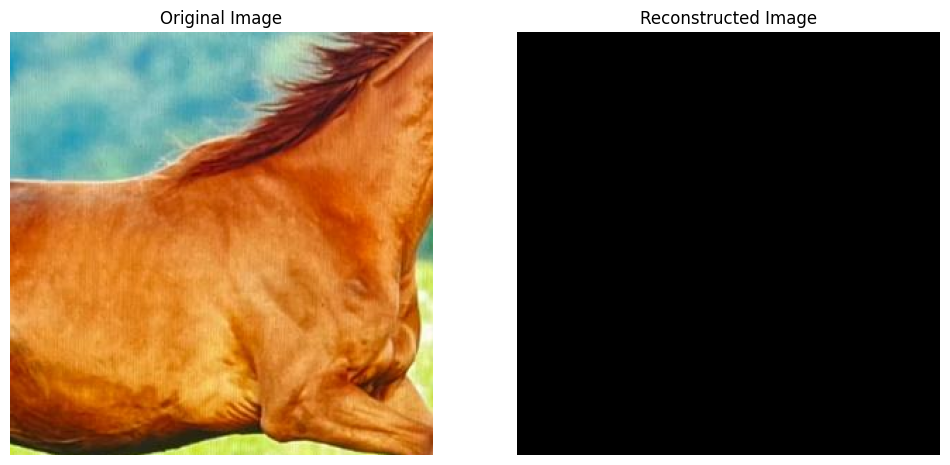

RMSE: nan
PSNR: nan dB


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

# Ensure reconstructed image is in the same range and format as original image
reconstructed_img = np.clip(reconstructed_img, 0, 1)  # Clip values to [0, 1]

# Convert original image from torch tensor to numpy array and ensure format HWC
original_img_np = cropped_img.permute(1, 2, 0).numpy()  # Convert to HWC format

# Transpose reconstructed image to HWC format
reconstructed_img_hwc = reconstructed_img.transpose(1, 2, 0)  # Convert to HWC format

# Check shapes for debugging
print(f"Original Image Shape: {original_img_np.shape}")
print(f"Reconstructed Image Shape: {reconstructed_img_hwc.shape}")

# Plot the original and reconstructed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(original_img_np)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(reconstructed_img_hwc)
ax[1].set_title("Reconstructed Image")
ax[1].axis('off')

plt.show()

# Compute RMSE and PSNR
rmse = np.sqrt(mse(original_img_np, reconstructed_img_hwc))
psnr_value = psnr(original_img_np, reconstructed_img_hwc, data_range=1.0)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr_value} dB")


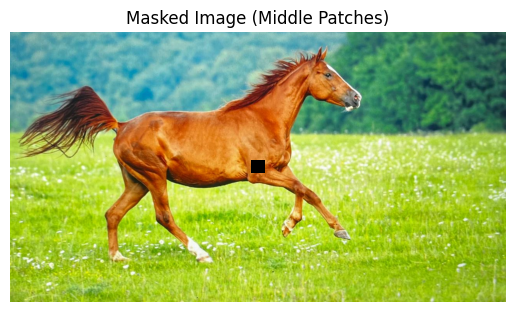

In [39]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

# Load the image as a tensor
img = torchvision.io.read_image("/kaggle/input/uydgcysg/Machine_learning.jpeg").float() / 255.0
img = img[:3, :, :]  # Ensure only RGB channels

# Function to mask a patch of the image in the middle region
def mask_image_patch_middle(img, patch_size, num_patches):
    img_copy = img.clone()
    h, w = img.shape[1:]

    # Define the middle region
    mid_h = h // 2
    mid_w = w // 2

    for _ in range(num_patches):
        # Randomly select a patch center within the middle region
        top = np.random.randint(mid_h - patch_size // 2, mid_h + patch_size // 2 - patch_size + 1)
        left = np.random.randint(mid_w - patch_size // 2, mid_w + patch_size // 2 - patch_size + 1)

        # Define the mask
        mask = torch.zeros_like(img[0], dtype=torch.bool)
        mask[top:top + patch_size, left:left + patch_size] = True

        # Apply the mask
        img_copy[:, mask] = float('nan')

    return img_copy

# Apply patch masking in the middle region
patch_size = 30
num_patches = 900 // (patch_size * patch_size)  # Total number of patches needed

masked_img = mask_image_patch_middle(img, patch_size, num_patches)

# Display the masked image
plt.imshow(masked_img.permute(1, 2, 0).numpy())
plt.title("Masked Image (Middle Patches)")
plt.axis('off')
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Factorization function (SVD / Gradient Descent-based approach can be used)
def factorize(masked_img, rank, device):
    # Initialize matrices W and H randomly
    W = torch.randn(masked_img.shape[0], rank, device=device, requires_grad=True)
    H = torch.randn(rank, masked_img.shape[1], device=device, requires_grad=True)
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Perform gradient descent
    for i in range(500):
        optimizer.zero_grad()
        pred = torch.mm(W, H)
        loss = criterion(torch.nan_to_num(masked_img), torch.nan_to_num(pred))
        loss.backward()
        optimizer.step()

    return W, H, loss.item()

# Factorize each channel
rank = 1500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
masked_img_device = masked_img.to(device)

W_r, H_r, loss_r = factorize(masked_img_device[0], rank, device)
W_g, H_g, loss_g = factorize(masked_img_device[1], rank, device)
W_b, H_b, loss_b = factorize(masked_img_device[2], rank, device)

# Reconstruct the image from W and H for each channel
reconstructed_r = torch.mm(W_r, H_r).cpu().detach().numpy()
reconstructed_g = torch.mm(W_g, H_g).cpu().detach().numpy()
reconstructed_b = torch.mm(W_b, H_b).cpu().detach().numpy()

# Stack the channels back together
reconstructed_img_matrix_factorization = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=0)

# Transpose to get the right shape for displaying (CHW -> HWC)
reconstructed_img_matrix_factorization = np.transpose(reconstructed_img_matrix_factorization, (1, 2, 0))

# Clip values to [0, 1] range to avoid any overflow in plotting
reconstructed_img_matrix_factorization = np.clip(reconstructed_img_matrix_factorization, 0, 1)

# Display the reconstructed image
plt.imshow(reconstructed_img_matrix_factorization)
plt.title("Reconstructed Image (Matrix Factorization)")
plt.axis('off')
plt.show()

# Print losses for each channel
print(f"Loss for R channel: {loss_r}")
print(f"Loss for G channel: {loss_g}")
print(f"Loss for B channel: {loss_b}")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to mask a 30x30 patch in the middle of the image
def mask_center_patch(image, patch_size=30):
    h, w = image.shape[1:]
    start_x, start_y = h // 2 - patch_size // 2, w // 2 - patch_size // 2
    end_x, end_y = start_x + patch_size, start_y + patch_size
    masked_image = image.clone()
    masked_image[:, start_x:end_x, start_y:end_y] = torch.nan  # Set patch to NaN
    return masked_image, (start_x, end_x, start_y, end_y)

# Matrix Factorization function (with masked handling)
def factorize(masked_img, rank, device):
    # Initialize W and H randomly
    W = torch.randn(masked_img.shape[0], rank, device=device, requires_grad=True)
    H = torch.randn(rank, masked_img.shape[1], device=device, requires_grad=True)
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Perform gradient descent while ignoring NaNs
    for i in range(500):
        optimizer.zero_grad()
        pred = torch.mm(W, H)
        mask = ~torch.isnan(masked_img)  # True where there are valid pixels, False for NaN (masked) pixels
        loss = criterion(torch.nan_to_num(masked_img)[mask], torch.nan_to_num(pred)[mask])  # Loss only for observed pixels
        loss.backward()
        optimizer.step()

    return W, H, loss.item()

# Load image (already done in your case)
# Mask the central 30x30 patch
masked_img, mask_coords = mask_center_patch(img)
plt.imshow(masked_img.permute(1, 2, 0).numpy())
plt.title("Masked Image (Center Patch Missing)")
plt.axis('off')
plt.show()

# Factorize each channel
rank = 100000  # Experiment with this value for better quality
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
masked_img_device = masked_img.to(device)

W_r, H_r, loss_r = factorize(masked_img_device[0], rank, device)
W_g, H_g, loss_g = factorize(masked_img_device[1], rank, device)
W_b, H_b, loss_b = factorize(masked_img_device[2], rank, device)

# Reconstruct the image from W and H for each channel
reconstructed_r = torch.mm(W_r, H_r).cpu().detach().numpy()
reconstructed_g = torch.mm(W_g, H_g).cpu().detach().numpy()
reconstructed_b = torch.mm(W_b, H_b).cpu().detach().numpy()

# Stack the channels back together
reconstructed_img_matrix_factorization = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=0)

# Transpose to get the right shape for displaying (CHW -> HWC)
reconstructed_img_matrix_factorization = np.transpose(reconstructed_img_matrix_factorization, (1, 2, 0))

# Clip values to [0, 1] range to avoid any overflow in plotting
reconstructed_img_matrix_factorization = np.clip(reconstructed_img_matrix_factorization, 0, 1)

# Display the reconstructed image
plt.imshow(reconstructed_img_matrix_factorization)
plt.title("Reconstructed Image (Matrix Factorization)")
plt.axis('off')
plt.show()

# Print losses for each channel
print(f"Loss for R channel: {loss_r}")
print(f"Loss for G channel: {loss_g}")
print(f"Loss for B channel: {loss_b}")


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import torch

def reconstruct_rff(masked_img, num_features=1000):
    h, w = masked_img.shape  # Extract image height and width
    coords = np.indices((h, w)).reshape(2, -1).T
    flat_img = masked_img.flatten()

    # Random Fourier Features
    np.random.seed(0)
    omega = np.random.randn(num_features, 2)
    beta = np.random.uniform(0, 2 * np.pi, num_features)

    features = np.sqrt(2 / num_features) * np.cos(coords @ omega.T + beta)

    # Linear Regression
    model = LinearRegression()
    observed = ~np.isnan(flat_img)
    model.fit(features[observed], flat_img[observed])

    # Predict missing values
    reconstructed_flat = model.predict(features)
    reconstructed_img = reconstructed_flat.reshape(h, w)

    return reconstructed_img

# Convert masked image to numpy arrays
masked_img_np = masked_img.numpy()

# Apply RFF for each channel
reconstructed_r_rff = reconstruct_rff(masked_img_np[0])
reconstructed_g_rff = reconstruct_rff(masked_img_np[1])
reconstructed_b_rff = reconstruct_rff(masked_img_np[2])

# Stack the channels back together
reconstructed_img_rff = np.stack([reconstructed_r_rff, reconstructed_g_rff, reconstructed_b_rff], axis=0)

# Assuming you have the original image loaded as `original_img` for evaluation
# Compute RMSE and PSNR
rmse_rff = np.sqrt(mse(original_img, reconstructed_img_rff))
psnr_rff = psnr(original_img, reconstructed_img_rff, data_range=1.0)

# Display the reconstructed image
import matplotlib.pyplot as plt
plt.imshow(np.transpose(reconstructed_img_rff, (1, 2, 0)))
plt.title("Reconstructed Image (RFF)")
plt.axis('off')
plt.show()

print(f"RMSE (RFF): {rmse_rff}")
print(f"PSNR (RFF): {psnr_rff} dB")


/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


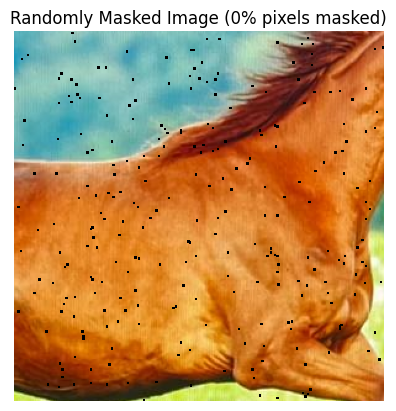

Iteration 0, Loss: 1484.8505859375
Iteration 100, Loss: 0.012465649284422398
Iteration 200, Loss: 4.294230109280761e-07
Iteration 300, Loss: 0.005650626961141825
Iteration 400, Loss: 1.246996959025637e-07
Iteration 0, Loss: 1484.188720703125
Iteration 100, Loss: 0.01238237228244543
Iteration 200, Loss: 3.9935477502694994e-07
Iteration 300, Loss: 0.007677968591451645
Iteration 400, Loss: 1.655954093848777e-07
Iteration 0, Loss: 1559.8446044921875
Iteration 100, Loss: 0.012350660748779774
Iteration 200, Loss: 4.102857644738833e-07
Iteration 300, Loss: 0.010717109777033329
Iteration 400, Loss: 7.502305834350409e-07
Iteration 0, Loss: 1468.255126953125
Iteration 100, Loss: 0.0121843870729208
Iteration 200, Loss: 4.0179435245590867e-07
Iteration 300, Loss: 0.01669198088347912
Iteration 400, Loss: 1.5124636831842508e-07
Iteration 0, Loss: 1484.6727294921875
Iteration 100, Loss: 0.012398031540215015
Iteration 200, Loss: 4.0507174503545684e-07
Iteration 300, Loss: 0.0023211075458675623
Iterati

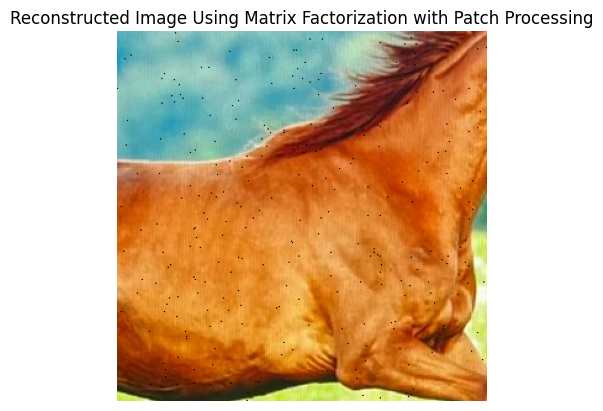

In [54]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load the image
img = torchvision.io.read_image("/kaggle/input/uydgcysg/Machine_learning.jpeg").float() / 255.0

# Convert RGBA to RGB if necessary
if img.shape[0] == 4:
    img = img[:3, :, :]  # Use only the RGB channels

# Crop the image randomly
np.random.seed(42)  # For reproducibility
num_channels, height, width = img.shape
crop_height, crop_width = 300, 300

# Random top-left corner for cropping
top = np.random.randint(0, height - crop_height)
left = np.random.randint(0, width - crop_width)

cropped_img = img[:, top:top + crop_height, left:left + crop_width]

# Masking process
mask_ratio = 0.003  # Mask 3% of the image

# Create the mask
masked_img = cropped_img.clone().numpy()  # Convert tensor to numpy for easy masking
num_pixels = crop_height * crop_width
num_masked_pixels = int(mask_ratio * num_pixels)

# Randomly select pixels to mask
masked_indices = np.random.choice(num_pixels, num_masked_pixels, replace=False)
masked_coords = np.unravel_index(masked_indices, (crop_height, crop_width))

# Apply the mask by setting selected pixels to NaN
for c in range(num_channels):
    masked_img[c, masked_coords[0], masked_coords[1]] = np.nan

# Convert back to tensor with NaN values for masked pixels
masked_img_tensor = torch.tensor(masked_img)

# Display the masked image
plt.imshow(masked_img_tensor.permute(1, 2, 0).numpy())
plt.title(f"Randomly Masked Image ({mask_ratio * 100:.0f}% pixels masked)")
plt.axis('off')
plt.show()

# Matrix Factorization function with refinement for masked parts
def factorize_part(masked_img_channel, rank, device, num_iters=500):
    # Flatten the image for the channel
    height, width = masked_img_channel.shape
    img_flat = masked_img_channel.flatten().unsqueeze(0)  # Flatten to a single row

    # Create a mask for known pixels (non-masked pixels)
    mask_flat = ~torch.isnan(img_flat)

    # Initialize matrices W and H
    W = torch.randn(1, rank, device=device, requires_grad=True)  # 1 x rank
    H = torch.randn(rank, height * width, device=device, requires_grad=True)  # rank x (height * width)

    # Optimizer and loss function
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    criterion = torch.nn.MSELoss()

    # Pre-fill the missing values with zeros or some initial guess
    img_flat_filled = torch.nan_to_num(img_flat)

    # Gradient descent with masked pixel refinement
    for i in range(num_iters):
        optimizer.zero_grad()
        
        # Predicted full image (W * H)
        pred = torch.mm(W, H)
        
        # Initially only use non-masked pixels to guide factorization
        if i < num_iters // 2:
            pred_masked = pred * mask_flat  # Apply the mask to only consider known values
            loss = criterion(img_flat_filled, pred_masked)  # Compute loss only for known values
        else:
            # Gradually use the entire image, including masked regions
            loss = criterion(img_flat_filled, pred)
        
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H

# Function to reconstruct the image from W and H
def predict_missing(W, H, img_shape):
    pred = torch.mm(W, H).reshape(img_shape)  # Reshape to original (height, width)
    return pred.cpu().detach().numpy()

# Apply Matrix Factorization locally on patches
patch_size = 50  # Define the patch size
stride = 50      # Define how much to move between patches

rank = 1500  # You can adjust the rank for each patch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

masked_img_tensor = masked_img_tensor.to(device)

# Initialize an array to store the reconstructed image
reconstructed_img = np.zeros_like(masked_img_tensor.cpu().numpy())

# Iterate over patches and apply matrix factorization
for i in range(0, crop_height, stride):
    for j in range(0, crop_width, stride):
        # Get the patch (ensure the patch size is within bounds)
        img_patch = masked_img_tensor[:, i:i+patch_size, j:j+patch_size]
        if img_patch.shape[1] != patch_size or img_patch.shape[2] != patch_size:
            continue  # Skip patches that don't match the patch size

        # Apply matrix factorization to each channel (R, G, B)
        W_r, H_r = factorize_part(img_patch[0, :, :], rank, device)
        W_g, H_g = factorize_part(img_patch[1, :, :], rank, device)
        W_b, H_b = factorize_part(img_patch[2, :, :], rank, device)

        # Reconstruct the patch
        reconstructed_r = predict_missing(W_r, H_r, (patch_size, patch_size))
        reconstructed_g = predict_missing(W_g, H_g, (patch_size, patch_size))
        reconstructed_b = predict_missing(W_b, H_b, (patch_size, patch_size))

        # Place the reconstructed patch back in the final image
        reconstructed_img[0, i:i+patch_size, j:j+patch_size] = reconstructed_r
        reconstructed_img[1, i:i+patch_size, j:j+patch_size] = reconstructed_g
        reconstructed_img[2, i:i+patch_size, j:j+patch_size] = reconstructed_b

# Step 4: Calculate RMSE and PSNR between original and reconstructed image
rmse_r = np.sqrt(mse(cropped_img[0].cpu().numpy(), reconstructed_img[0]))
rmse_g = np.sqrt(mse(cropped_img[1].cpu().numpy(), reconstructed_img[1]))
rmse_b = np.sqrt(mse(cropped_img[2].cpu().numpy(), reconstructed_img[2]))
rmse_total = np.sqrt(mse(cropped_img.cpu().numpy().flatten(), reconstructed_img.flatten()))

# Compute PSNR for the overall image
psnr_value = psnr(cropped_img.cpu().numpy(), reconstructed_img, data_range=1)

print(f"RMSE (R): {rmse_r:.4f}")
print(f"RMSE (G): {rmse_g:.4f}")
print(f"RMSE (B): {rmse_b:.4f}")
print(f"Total RMSE: {rmse_total:.4f}")
print(f"PSNR: {psnr_value:.2f}")

# Plot the reconstructed image
plt.imshow(reconstructed_img.transpose(1, 2, 0))  # (H, W, C)
plt.title("Reconstructed Image Using Matrix Factorization with Patch Processing")
plt.axis('off')
plt.show()
